# System do wykrywania twarzy Roberta Lewandowskiego

## Importy

In [8]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import torch
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

## Przygotowanie modelu detekcji twarzy i modelu embedingów

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(image_size=160, margin=20, keep_all=True, device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

## Wczytanie zdjęcia referencyjnego Lewandowskiego oraz ekstrakcja embedingów

In [10]:
# Wczytywanie zdjęć referencyjnych
ref_imgs_dir = "C:/Users/Admin/Desktop/Projekt_z_AI/Lewy_zdjecia/" #ścieżka do katalogu ze zdjęciami referencyjnymi
ref_img_paths = [os.path.join(ref_imgs_dir, f) for f in os.listdir(ref_imgs_dir) if f.endswith('.jpg') or f.endswith('.png')]

ref_embeddings = []
for img_path in ref_img_paths:
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    face = mtcnn(img) 
    if face is not None:
        if isinstance(face, list) or len(face.shape) == 4:
            face = face[0]
        face = face.unsqueeze(0).to(device)
        emb = resnet(face).detach()
        ref_embeddings.append(emb)
if len(ref_embeddings) == 0:
    raise Exception("Nie udało się wygenerować żadnego embeddingu referencyjnego!")
ref_embeddings = torch.cat(ref_embeddings)  # shape: [N, 512]

## Przetwarzanie wszystkich zdjęć z folderu "Test"


Przetwarzanie: test1.png


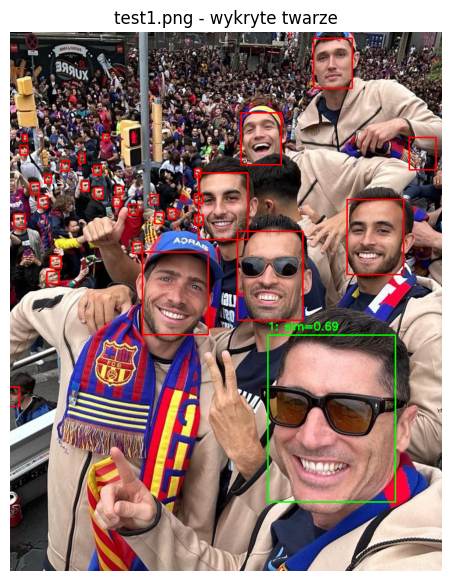


Przetwarzanie: test2.png


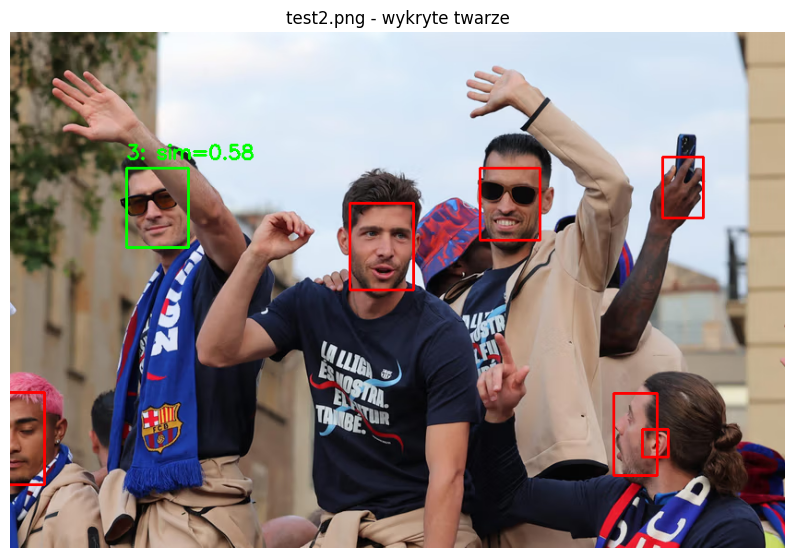


Przetwarzanie: test3.png


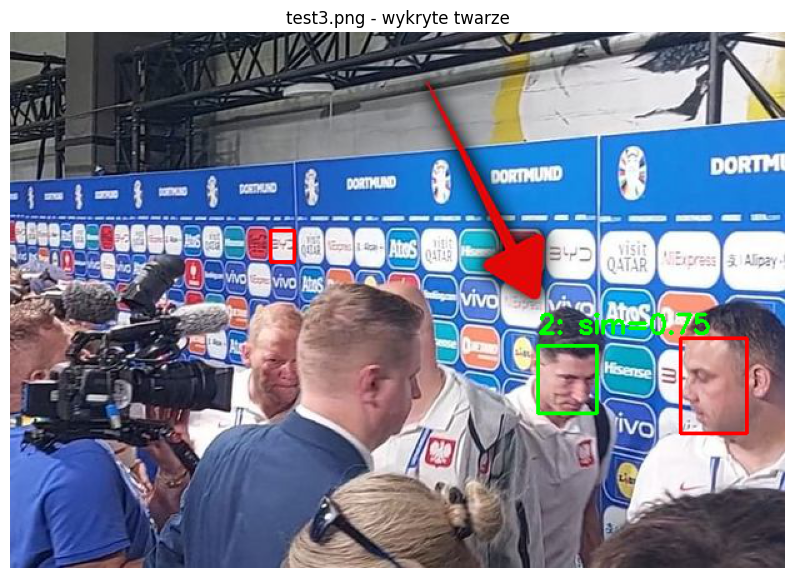


Przetwarzanie: test4.png


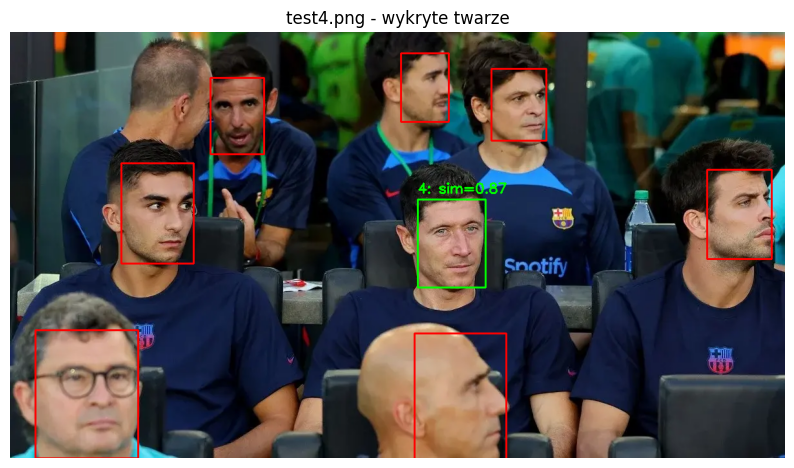


Przetwarzanie: test5.png


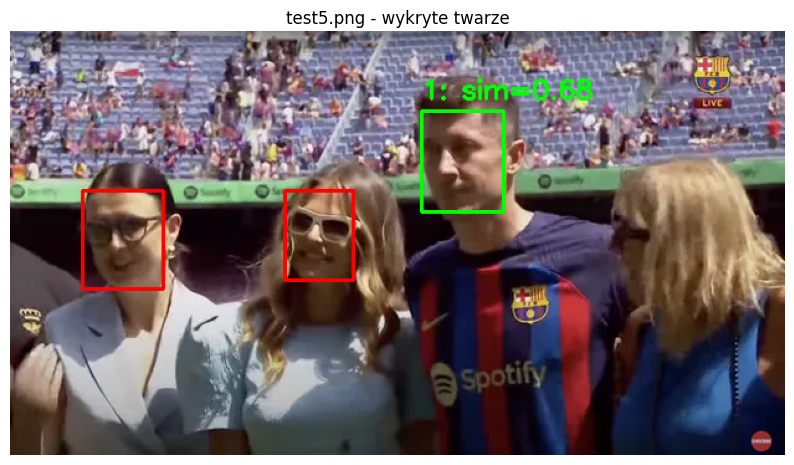


Przetwarzanie: test6.png


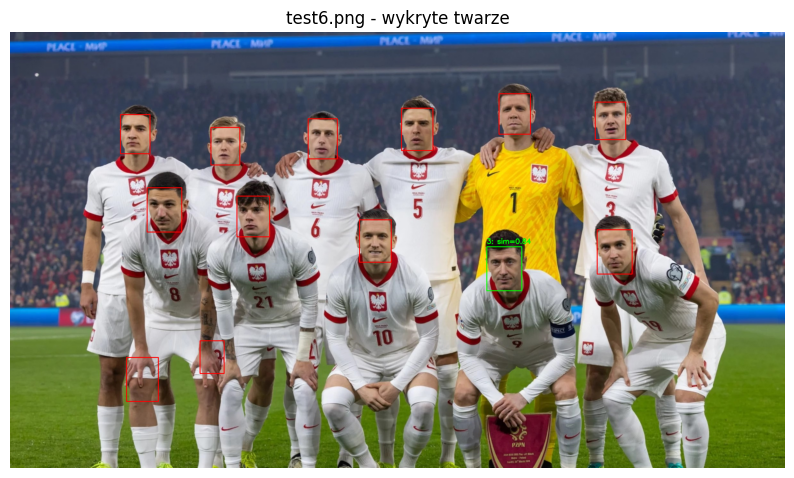


Przetwarzanie: test7.png


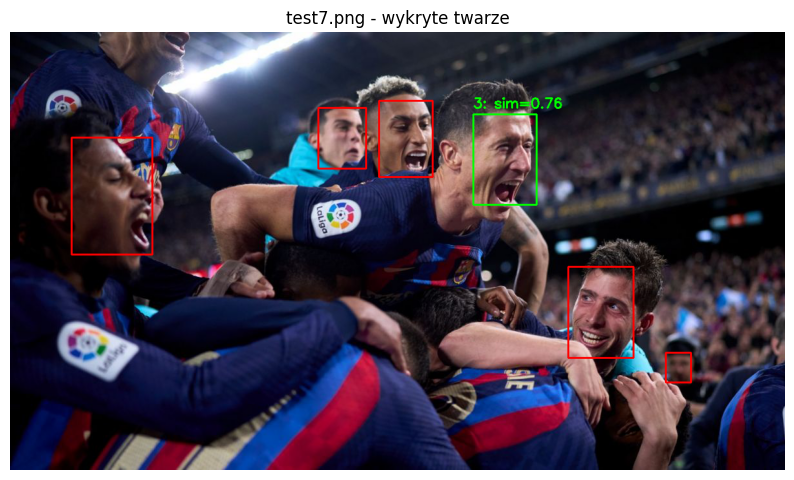


Przetwarzanie: test8.png


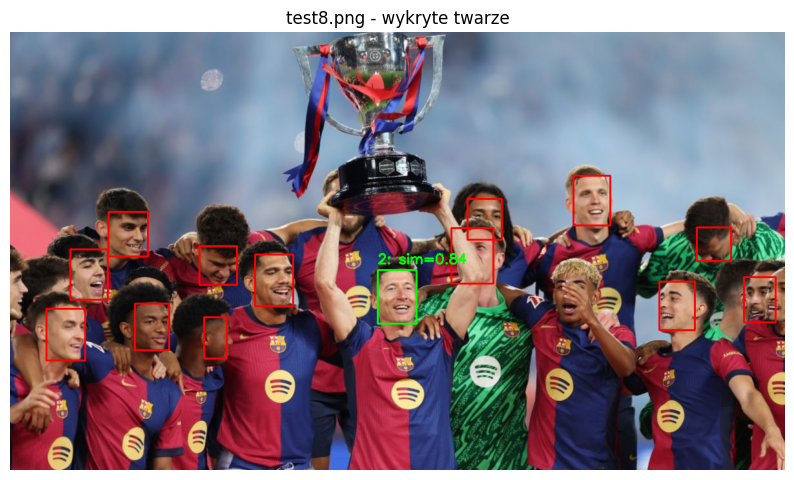


Przetwarzanie: test9.png


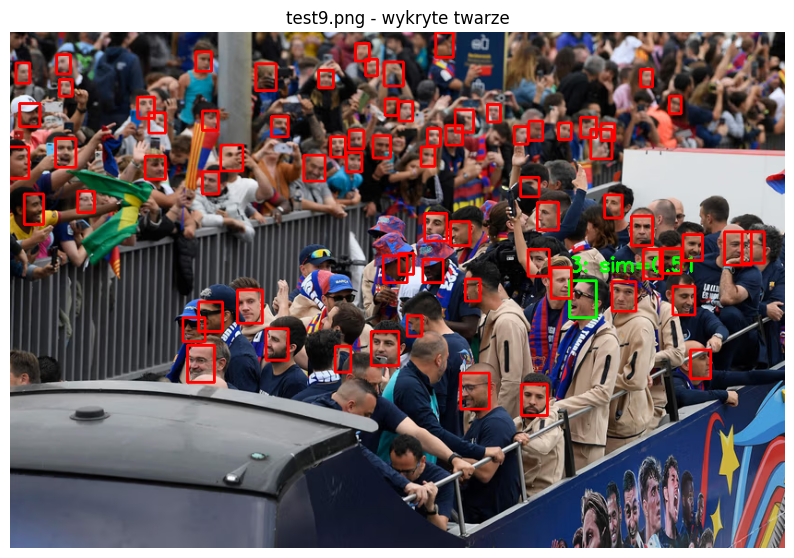


Przetwarzanie: test10.png


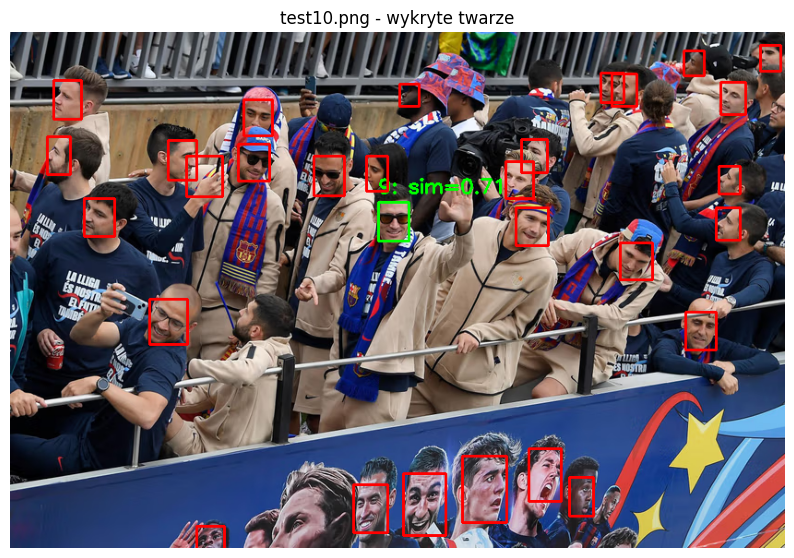


Przetwarzanie: test11.png


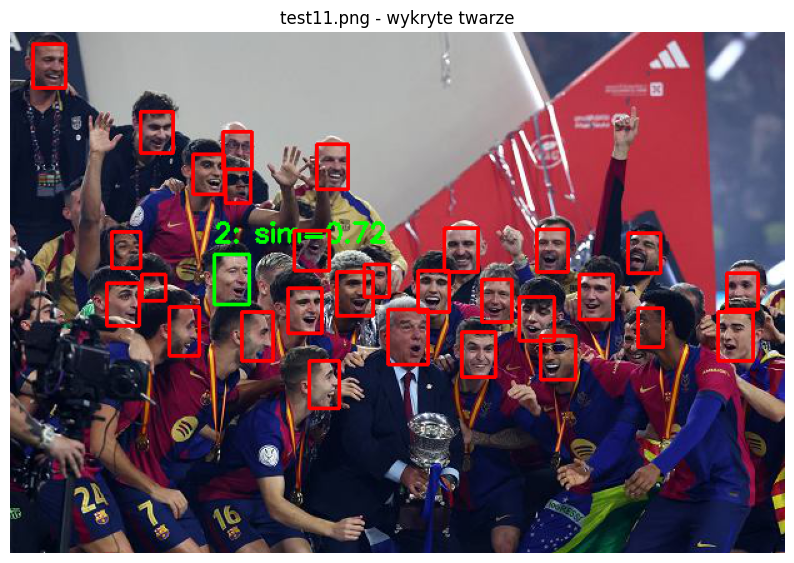

Plik nie istnieje: C:/Users/Admin/Desktop/Projekt_z_AI/Test\test12.png


In [11]:
threshold = 0.5  # Próg podobieństwa od którego uznajemy, że twarz jest rozpoznana

test_folder = "C:/Users/Admin/Desktop/Projekt_z_AI/Test"
test_img_paths = [os.path.join(test_folder, f"test{i}.png") for i in range(1, 13)]

for test_img_path in test_img_paths:
    if not os.path.exists(test_img_path):
        print(f"Plik nie istnieje: {test_img_path}")
        continue

    test_img = Image.open(test_img_path)
    if test_img.mode != 'RGB':
        test_img = test_img.convert('RGB')  # KONWERSJA DO RGB

    boxes, faces = mtcnn.detect(test_img, landmarks=False), mtcnn(test_img)

    print(f"\nPrzetwarzanie: {os.path.basename(test_img_path)}")
    if faces is None or (isinstance(faces, list) and len(faces) == 0):
        print("Nie wykryto twarzy na zdjęciu.")
        continue

    if isinstance(faces, torch.Tensor):
        faces = [faces[i] for i in range(faces.shape[0])]
    embeddings = []
    for face in faces:
        emb = resnet(face.unsqueeze(0).to(device)).detach()
        embeddings.append(emb)
    embeddings = torch.cat(embeddings)  # [M, 512]

    from torch.nn.functional import cosine_similarity
    # Porównanie każdej twarzy testowej do wszystkich embeddingów referencyjnych
    # Wynik: dla każdej twarzy testowej bierzemy max podobieństwo do referencyjnych
    scores = []
    for emb in embeddings:
        sims = cosine_similarity(emb.unsqueeze(0), ref_embeddings)
        score = sims.max().item()  # lub np. sims.mean().item() dla średniej
        scores.append(score)

    img_cv = np.array(test_img)
    if img_cv.shape[2] == 4:
        img_cv = img_cv[:, :, :3]
    for idx, (box, score) in enumerate(zip(boxes[0], scores)):
        x1, y1, x2, y2 = [int(b) for b in box]
        if score > threshold:
            color = (0, 255, 0)
            label = f"{idx+1}: sim={score:.2f}"
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_cv, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        else:
            color = (255, 0, 0)
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), color, 2)
    plt.figure(figsize=(10,7))
    plt.imshow(img_cv)
    plt.axis("off")
    plt.title(f"{os.path.basename(test_img_path)} - wykryte twarze")
    plt.show()

## Wykrywanie twarzy na żywo

In [12]:
threshold = 0.5  # Próg podobieństwa

cap = cv2.VideoCapture(0)  # 0 = domyślna kamera

print("Naciśnij 'q', aby zakończyć.")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Konwersja do RGB i PIL.Image
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img)

    # Detekcja twarzy
    boxes, faces = mtcnn.detect(pil_img, landmarks=False), mtcnn(pil_img)

    if faces is not None and not (isinstance(faces, list) and len(faces) == 0):
        if isinstance(faces, torch.Tensor):
            faces = [faces[i] for i in range(faces.shape[0])]
        embeddings = []
        for face in faces:
            emb = resnet(face.unsqueeze(0).to(device)).detach()
            embeddings.append(emb)
        embeddings = torch.cat(embeddings)

        from torch.nn.functional import cosine_similarity
        scores = []
        for emb in embeddings:
            sims = cosine_similarity(emb.unsqueeze(0), ref_embeddings)
            score = sims.max().item()
            scores.append(score)

        for idx, (box, score) in enumerate(zip(boxes[0], scores)):
            x1, y1, x2, y2 = [int(b) for b in box]
            if score > threshold:
                color = (0, 255, 0)
                label = f"Lewandowski: {score:.2f}"
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            else:
                color = (255, 0, 0)
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

    cv2.imshow("Lewandowski Finder - Kamera", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Naciśnij 'q', aby zakończyć.
